# 1. MNIST

In [1]:
from sklearn.datasets import fetch_openml

In [2]:
mnist = fetch_openml("mnist_784",version=1)

/Users/ijiseon/opt/anaconda3/lib/python3.9/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist["data"], mnist["target"]

In [5]:
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

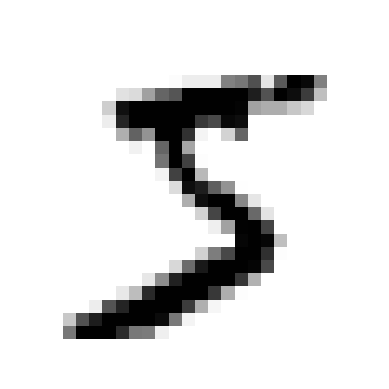

In [9]:
import pandas as pd

X_df = pd.DataFrame(X)


some_digit = X_df.iloc[0]


some_digit_image = some_digit.values.reshape(28, 28)


plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()


In [10]:
y[0]

'5'

In [13]:
import numpy as np

y = y.astype(np.uint8)

In [14]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y [:60000], y[60000:]

# 2. 이진 분류기 훈련

In [15]:
# 5-감지기는 5와 5 아님 두 개의 클래스를 구분할 수있는 이진분류기의 한 예 

y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

> 확률적 경사 하강법 (SGD)

- 이 분류기는 매우 큰 데이터셋을 효율적으로 처리하는 장점을 지니고 있음 <br>
: SGD가 한 번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문 

In [16]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [17]:
sgd_clf.predict([some_digit])

/Users/ijiseon/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

# 3. 성능 측정 

> 교차검증을 사용한 정확도 측정 

In [21]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds=X_train.iloc[train_index]
    y_train_folds = y_train_5.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train_5.iloc[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred=clone_clf.predict(X_test_fold)
    n_correct=sum(y_pred==y_test_fold)
    print(n_correct/len(y_pred))

0.95275
0.94985
0.9574


In [22]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [23]:
# 모든 이미지를 "5 아님" 클래스로 분류하는 더미 분류기를 만듦

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self,X):
        return np.zeros((len(X),1), dtype=bool)

In [24]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

- 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유

- 특히 불균형한 데이터셋을 다룰 때, 더욱 그렇다

> 오차행렬

In [25]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [26]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [27]:
y_train_perfect_predictions = y_train_5

confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

> 정밀도와 재현율 

- 정밀도 : 양성 예측의 정확도 (양성으로 예측한 수 중 진짜 양성의 수 / 양성으로 예측한 수)

- 재현율(=민감도) : 진짜 양성 비율 (실제 양성 중 양성으로 예측한 수 /실제 양성)

In [28]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [29]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [30]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

- 정밀도와 재현율이 비슷한 분류기에서는 F1 점수가 높습니다.

- 상황에 따라 정밀도가 중요할 수도 있고 재현율이 중요할 수도 있습니다. <br>

예1) 어린아이에게 안전한 동영상을 걸러내는 분류기를 훈련시킨다고 가정.<br>
재현율은 높으나 정말 나쁜 동영상이 몇 개 노출되는 것보다 좋은 동영상이 많이 제외되더라도 (낮은 재현율) 안전한 것들만 노출시키는 (높은 정밀도) 분류기를 선호할 것입니다<br>
이런 경우에는 분류기의 동영상 선택 결과를 확인하기 위해 사람이 참여하는 분석 파이프라인을 추가할지도 모릅니다. <br>

예2) 감시 카메라를 통해 좀도둑을 잡아내는 분류기를 훈련시킨다고 가정 <br>
분류기의 재현율이 99%라면 정확도가 30%만 되더라도 괜찮을지 모릅니다 (아마도 경비원이 잘못된 호출을 종종 받게 되겠지만, 거의 모든 좀도둑을 잡을 것입니다) <br>

이 둘을 모두 얻을 수는 없습니다. 정밀도를 올리면 재현율이 줄고 그 반대도 마찬가지 <br>
이를 정밀도/재현율 트레이드 오프 <br>

> 정밀도 / 재현율 트레이드 오프

In [32]:
y_scores = sgd_clf.decision_function([some_digit])

/Users/ijiseon/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


In [33]:
y_scores

array([2164.22030239])

In [34]:
threshold=0

In [35]:
y_some_digit_pred = (y_scores>threshold)

In [36]:
y_some_digit_pred

array([ True])

In [37]:
threshold=8000

In [38]:
y_some_digit_pred = (y_scores>threshold)

In [39]:
y_some_digit_pred

array([False])

In [40]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [41]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve( y_train_5, y_scores)

In [42]:
def plot_precision_recall_vs_threshold(precisions,recalls, thresholds):
    plt.plot(thresholds, precisions[:-1],"b--", label="정밀도")
    plt.plot(thresholds, recalls[:-1],"g-", label="재현율")

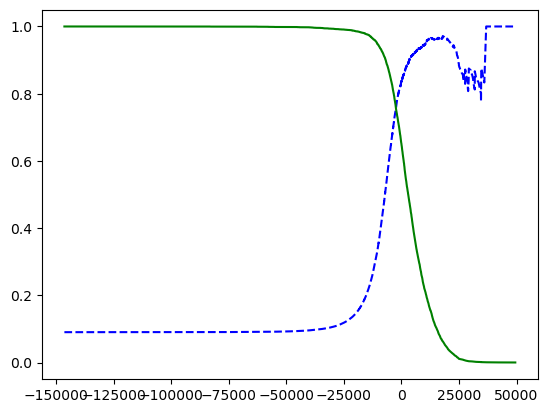

In [43]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [44]:
threshold_90_precision = thresholds[np.argmax(precisions>=0.9)]

In [45]:
y_train_pred_90 = (y_scores>= threshold_90_precision)

In [46]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [47]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

> ROC 곡선

In [48]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [49]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr,tpr,linewidth=2, label=label)
    plt.plot([0,1],[0,1],"k--")

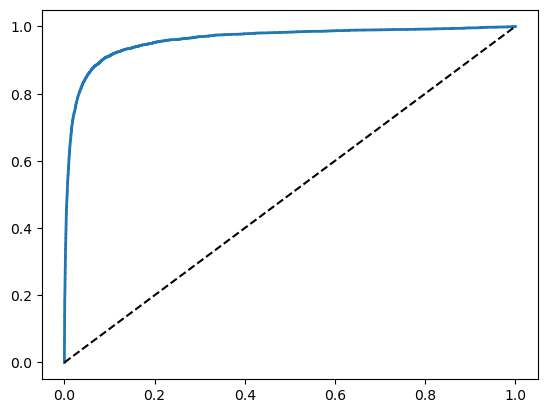

In [50]:
plot_roc_curve(fpr,tpr)
plt.show()

In [51]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [52]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=43)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5,cv=3, method="predict_proba")

In [54]:
y_scores_forest = y_probas_forest[:,1] # 양성 클래스에 대한 확률을 점수로 사용

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

/Users/ijiseon/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47004 (\N{HANGUL SYLLABLE RAEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ijiseon/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45924 (\N{HANGUL SYLLABLE DEOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ijiseon/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ijiseon/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47112 (\N{HANGUL SYLLABLE RE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ijiseon/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current fon

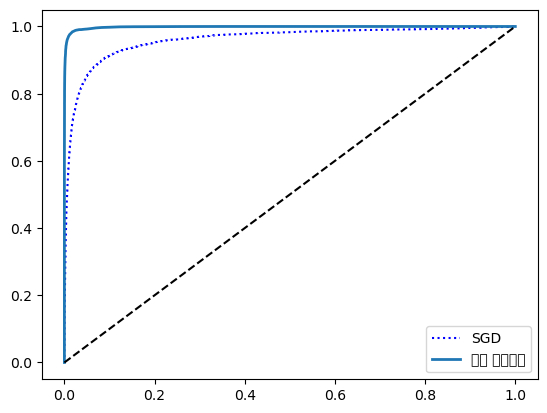

In [55]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "랜덤 포레스트")
plt.legend(loc="lower right")
plt.show()

In [56]:
roc_auc_score(y_train_5, y_scores_forest)

0.9984888909627533

# 4. 다중분류 

- 이진분류가 두 개의 클래스를 구별하는 반면 다중 분류기 (다항분류기)는 둘 이상의 클래스를 구별할 수 있음


- SGD 분류기, 랜덤포레스트 분류기, 나이브 베이즈 분류기 같은 일부 알고리즘은 여러 개의 클래스를 직접 처리할 수 있는 반면, 로지스틱 회귀나 서포트 벡터 머신 분류기 같은 다른 알고리즘은 이진 분류만 가능. 하지만 이진 분류기를 여러 개 사용해 다중 클래스를 분류하는 기법도 많음. 


- 예를 들어 특정 숫자 하나만 구분하는 숫자별 이진 분류기 10개(0에서 부터 9까지)를 훈련시켜 클래스가 10개인 숫자 이미지 분류 시스템을 만들 수 있음. 이미지를 분류할 때 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스를 선택하면 됨 이를 OvR(OvA) 전략이라고 함


- 또 다른 전략은 0과 1구별, 0과 2구별, 1과 2 구별 등과 같이 각 숫자의 조합마다 이진 분류기를 훈련시키는 것입니다. 이를 OvO 전략이라고 함. 클래스가 N개라면 분류기는 N*(N-1)/2개가 필요 -> MNIST 문제에서는 45개의 분류기를 훈련시켜야함 ; 이미지 하나를 분류하려면 45개 분류기 모두를 통과시켜서 가장 많이 양성으로 분류된 클래스를 선택. OvO 전략의 주요 장점은 각 분류기의 훈련에 전체 훈련 세트 중 구별할 두 클래스에 해당하는 샘플만 필요 

- (서포트 벡터 머신 같은) 일부 알고리즘은 훈련 세트의 크기에 민감해서 큰 훈련 세트에서 몇 개의 분류기를 훈련시키는 것보다 작은 훈련 세트에서 많은 분류기를 훈련시키는 쪽이 빠르므로 OvO를 선호함. 하지만 대부분의 이진 분류 알고리즘에서 OvR을 선호

In [60]:
from sklearn.svm import SVC

svm_clf = SVC()

In [61]:
svm_clf.fit(X_train,y_train)

SVC()

In [63]:
svm_clf.predict([some_digit])

/Users/ijiseon/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

In [64]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

/Users/ijiseon/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [65]:
np.argmax(some_digit_scores)

5

In [66]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [67]:
svm_clf.classes_[5]

5

- 사이킷런에서 OvO나 OvR을 사용하도록 강제하려면 OneVsOneClassifier나 OneVsRestClassifier를 사용합니다.

In [70]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())

In [71]:
ovr_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC())

In [72]:
ovr_clf.predict([some_digit])

/Users/ijiseon/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/ijiseon/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/ijiseon/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/ijiseon/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/ijiseon/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/ijiseon/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:465: UserWar

array([5], dtype=uint8)

In [73]:
len(ovr_clf.estimators_)

10

In [74]:
sgd_clf.fit(X_train,y_train)
sgd_clf.predict([some_digit])

/Users/ijiseon/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([3], dtype=uint8)

In [75]:
sgd_clf.decision_function([some_digit])

/Users/ijiseon/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [76]:
cross_val_score(sgd_clf,X_train,y_train,cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [77]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# 5.에러분석

- 오차행렬 살펴볼 수 있음 

: 많은 숫자가 출력 -> 오차행렬을 맷플롯립의 matshow()함수를 사용해 이미지로 표현 

In [78]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

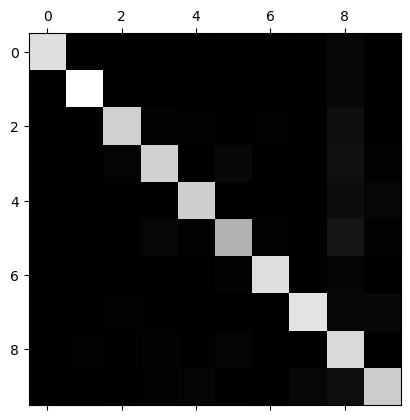

In [79]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

- 이 오차행렬은 대부분의 이미지가 올바르게 분류되었음을 나타내는 주대각선에 있으므로 매우 좋아보임

- 숫자 5는 다른 숫자보다 조금 더 어두워 보임.<br>
= 이는 데이터셋에 숫자 5의 이미지가 적거나 분류기가 숫자 5를 다른 숫자만큼 잘 분류하지 못한다는 뜻

> 그래프의 에러 부분에 초점! 

- 먼저 오차행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어 에러 비율을 비교 <br>
개수로 비교하면 이미지가 많은 클래스가 상대적으로 나쁘게 보이기 때문 


In [80]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

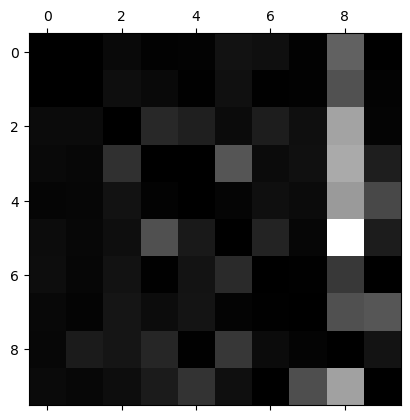

In [81]:
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

- 행은 실제 클래스를 나타내고 열은 예측한 클래스

- 클래스 8의 열이 상당히 밝으므로 많은 이미지가 8로 잘못 분류되고 있음을 암시. 하지만 클래스 8의 행은 그리 나쁘지 않음. 즉 실제 8이 적절히 8로 분류되었음 

- 오차 행렬은 반드시 대칭인 것은 아님. 3과 5가 많이 혼동되고 있는 것도 볼 수 있음

In [82]:
cl_a, cl_b =3,5

X_aa = X_train[(y_train==cl_a) & (y_train_pred==cl_a)]
X_ab = X_train[(y_train==cl_a) & (y_train_pred==cl_b)]
X_ba = X_train[(y_train==cl_b) & (y_train_pred==cl_a)]
X_bb = X_train[(y_train==cl_b) & (y_train_pred==cl_b)]

In [89]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")




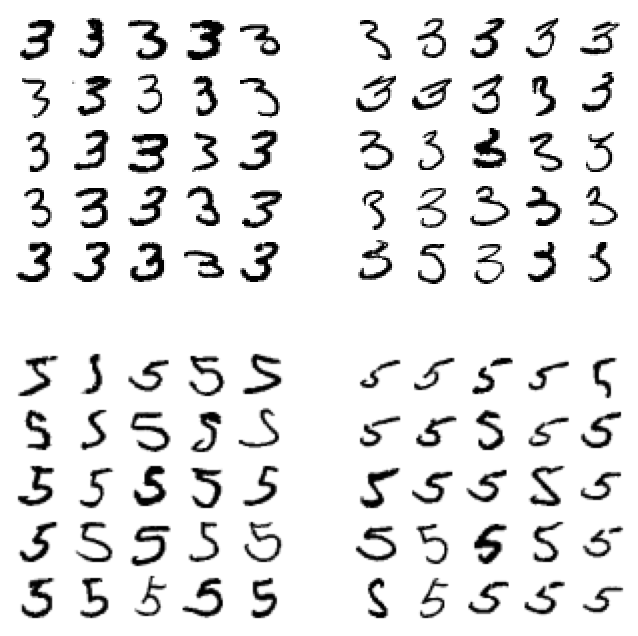

In [90]:
plt.figure(figsize=(8,8))
plt.subplot(221);plot_digits(X_aa[:25],images_per_row=5)
plt.subplot(222);plot_digits(X_ab[:25],images_per_row=5)
plt.subplot(223);plot_digits(X_ba[:25],images_per_row=5)
plt.subplot(224);plot_digits(X_bb[:25],images_per_row=5)
plt.show()

# 6. 다중 레이블 분류

: 지금까지는 각 샘플이 하나의 클래스에만 할당. 하지만 분류기가 샘플마다 여러 개의 클래스를 출력해야 할 때도 있음

- 얼굴 인식 분류기

: 같은 사진에 여러 사람이 등장한다면 어떻게 해야 할까요? <br>
인식된 사람마다 하나씩 꼬리표를 붙여야 합니다. 분류기가 앨리스, 밥, 찰리 세 얼굴을 인식하도록 훈련되었다고 가정<br>
분류기가 앨리스와 찰리가 있는 사진을 본다면 [1,0,1]을 출력 = 즉 앨리스 있음 , 밥 없음, 찰리 있음<br>


In [91]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train>=7)
y_train_odd = (y_train%2==1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

첫 번째는 숫자가 큰 값(7,8,9)인지 나타내고 두 번째는 홀수인지 나타냄  

In [92]:
knn_clf.predict([some_digit])

/Users/ijiseon/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([[False,  True]])

올바르게 분류됨 -> 숫자5는 크지 않고 홀수임 (True, False) 

In [94]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

# 7. 다중 출력 분류

- 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화 한 것

- 이미지에서 잡음을 제거하는 시스템

: 잡음이 많은 숫자 이미지를 입력으로 받고 깨끗한 숫자 이미지를 MNIST 이미지처럼 픽셀의 강도를 담은 배열로 출력합니다. 분류기의 출력이 다중 레이블 (픽셀 당 한 레이블)이고 각 레이블은 값을 여러 개 가집니다. (0부터 255까지 픽셀 강도) 그러므로 이 예는 다중 출력 분류 시스템

In [95]:
noise = np.random.randint(0,100,(len(X_train), 784))
X_train_mod = X_train+noise
noise = np.random.randint(0,100,(len(X_test),784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [98]:
some_index = 4

/Users/ijiseon/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


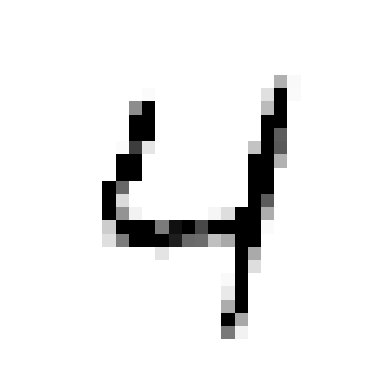

In [101]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod.iloc[some_index]])
plot_digits(clean_digit)